# Angular correlation of bright object in LSST

In [1]:
import astropy.units as u
import numpy as np 
import pandas as pd
pd.set_option("display.max_columns", None)
from astropy.time import Time

import scipy.stats

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm,SymLogNorm
from matplotlib.patches import Circle,Annulus


import lsst.geom as geom
import pickle
from astropy.stats import SigmaClip

In [2]:
from astropy.io import fits
from astropy.wcs import WCS


import pandas as pd
pd.set_option("display.max_columns", None)
pd.set_option('display.max_rows', 100)

import matplotlib.ticker                         # here's where the formatter is
import os
import re
import pandas as pd
import pickle
from collections import OrderedDict

plt.rcParams["figure.figsize"] = (4,3)
plt.rcParams["axes.labelsize"] = 'xx-large'
plt.rcParams['axes.titlesize'] = 'xx-large'
plt.rcParams['xtick.labelsize']= 'xx-large'
plt.rcParams['ytick.labelsize']= 'xx-large'

import scipy
from scipy.optimize import curve_fit

In [3]:
import lsst
import lsst.sphgeom
from  lsst.geom import SpherePoint, Angle

#spherePointCenter = lsst.geom.SpherePoint(ra1*lsst.geom.degrees, dec1*lsst.geom.degrees)
#spt = lsst.geom.SpherePoint(ra2*lsst.geom.degrees, dec2*lsst.geom.degrees)
#ang = spherePointCenter.separation(spt)
#ang_arcsec = ang.asArcseconds()

In [4]:
def calculateSeparation(ra0,dec0,ra,dec):
    spt0 = lsst.geom.SpherePoint(ra0*lsst.geom.degrees, dec0*lsst.geom.degrees)
    spt = lsst.geom.SpherePoint(ra*lsst.geom.degrees, dec*lsst.geom.degrees)
    ang = spt0.separation(spt)
    ang_arcsec = ang.asArcseconds()
    return ang_arcsec
 

In [5]:
from lsst.geom import Angle 
import lsst
func_degToRad = lambda x : Angle(x,lsst.geom.degrees).asRadians()
func_degToArcsec = lambda x : Angle(x,lsst.geom.degrees).asArcseconds()

In [6]:
df = pd.read_csv("list_of_isolatedobjects.csv",index_col=0)

In [7]:
df.head()

,idx_obj,ra,dec,magG,magR,magI,magZ,magY,smagG,smagR,smagI,smagZ,smagY,G_R,Z_Y,racosdec
0,64.0,122.458942,-36.203409,15.777598,15.297151,15.071238,14.976599,14.989068,0.015889,0.015765,0.014891,0.019052,0.020214,0.480447,-0.094639,98.815202
1,97.0,122.443233,-36.188544,16.445436,15.197609,14.557551,14.211738,14.017541,0.024000,0.018429,0.016975,0.019177,0.030711,1.247827,-0.345813,98.821287
2,101.0,122.558798,-36.184124,14.703564,13.660735,13.141518,12.922712,12.838508,0.021051,0.017896,0.014409,0.016356,0.039974,1.042829,-0.218806,98.920140
3,108.0,122.476591,-36.168954,13.855744,13.133155,12.888260,12.779664,12.791271,0.022899,0.018386,0.020533,0.021819,0.034599,0.722588,-0.108596,98.872928
4,109.0,122.556550,-36.138404,15.638559,15.115679,14.870493,14.803328,14.853112,0.019506,0.015110,0.016687,0.019926,0.045657,0.522880,-0.067165,98.976031


## Calculation of angle correlation

In [8]:
all_df = []
for index, row in df.iterrows():
    ra0 = row['ra']
    dec0 = row['dec']
    df1 = df.copy(deep=True)
    df1 = df1.iloc[index+1:] 
    df1["sep"]=df1.apply(lambda x : calculateSeparation(ra0,dec0,x['ra'],x['dec']),axis=1)
    all_df.append(df1)

## Separation angle distribution

In [9]:
all_sep = []
for df1 in all_df:
    if len(df1)>0:
        list_of_sep = df1["sep"].values
        all_sep.append(list_of_sep)
all_sep = np.concatenate(all_sep, axis=0)

In [10]:
image_size = 0.1*4000.

Text(0.5, 1.0, 'Bright source correlation ')

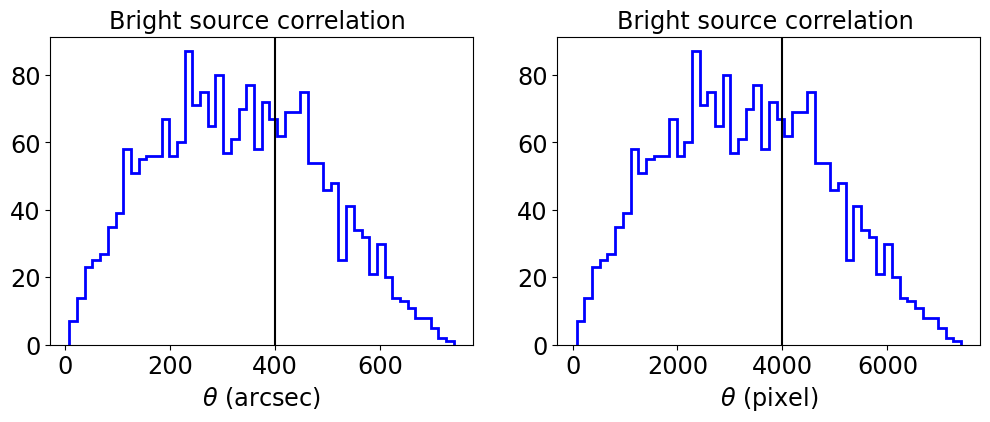

In [11]:
fig,axs = plt.subplots(1,2,figsize=(12,4))
ax1,ax2=axs
ax1.hist(all_sep,bins=50,histtype="step",color="b",lw=2);
image_size = 0.1*4000.
ax1.axvline(image_size,color="k")
ax1.set_xlabel("$\\theta$ (arcsec)")
ax1.set_title("Bright source correlation ")

all_sep_pix = all_sep/0.1
ax2.hist(all_sep_pix,bins=50,histtype="step",color="b",lw=2);
image_size = 4000.
ax2.axvline(image_size,color="k")
ax2.set_xlabel("$\\theta$ (pixel)")
ax2.set_title("Bright source correlation ")


## Save 

In [12]:
all_pairs = []
for index, row in df.iterrows():
    idx0 = int(row["idx_obj"] )	
    ra0 = row['ra']
    dec0 = row['dec']
    G_R0 = row['G_R']
    Z_Y0 = row['Z_Y']
    df1 = all_df[index]
    for index1, row1 in df1.iterrows():
        idx1 = int(row1['idx_obj']) 	
        ra1 = row1['ra']
        dec1 = row1['dec']
        G_R1 = row1['G_R']
        Z_Y1 = row1['Z_Y']
        sep = row1['sep']
        all_pairs.append(np.array([idx0,idx1,G_R0,G_R1,Z_Y0,Z_Y1,sep]))
        
all_pairs = np.vstack(all_pairs)    

In [13]:
all_pairs 

array([[ 6.40000000e+01,  9.70000000e+01,  4.80447110e-01, ...,
        -9.46389306e-02, -3.45812927e-01,  7.03321612e+01],
       [ 6.40000000e+01,  1.01000000e+02,  4.80447110e-01, ...,
        -9.46389306e-02, -2.18805640e-01,  2.98304672e+02],
       [ 6.40000000e+01,  1.08000000e+02,  4.80447110e-01, ...,
        -9.46389306e-02, -1.08596244e-01,  1.34220132e+02],
       ...,
       [ 9.58000000e+02,  9.63000000e+02,  2.88732780e-01, ...,
                    nan,             nan,  3.40558710e+02],
       [ 9.58000000e+02,  9.83000000e+02,  2.88732780e-01, ...,
                    nan,             nan,  5.10243387e+02],
       [ 9.63000000e+02,  9.83000000e+02,  6.60575166e-01, ...,
                    nan,             nan,  7.40247857e+02]])

In [14]:
df_pairs = pd.DataFrame(all_pairs, columns=["objidx1","objidx2","G1_R1","G2_R2","Z1_Y1","Z2_Y2","sep"] )

In [15]:
df_pairs.sort_values("sep",axis=0, ascending=True, inplace=True)

In [16]:
df_pairs

,objidx1,objidx2,G1_R1,G2_R2,Z1_Y1,Z2_Y2,sep
606,141.0,907.0,0.735042,0.980283,-0.114436,NaN,7.953708
2060,654.0,669.0,0.331201,0.533893,0.007770,-0.191827,10.576831
333,111.0,262.0,0.540740,0.144065,-0.112162,0.005726,16.129314
2152,813.0,950.0,0.864215,1.371627,-0.175939,NaN,16.859074
18,64.0,262.0,0.480447,0.144065,-0.094639,0.005726,18.288013
...,...,...,...,...,...,...,...
2169,865.0,944.0,0.809207,1.055756,-0.080143,NaN,707.396851
1774,527.0,963.0,1.221065,0.660575,-0.284526,NaN,708.301749
1506,440.0,963.0,0.278058,0.660575,-0.006838,NaN,712.726810
1389,392.0,963.0,0.474475,0.660575,-0.020272,NaN,715.843647


In [17]:
df_pairs.to_csv("all_pairs.csv")